# Demonstration of basic geoDB capabilities + Use Case #2

## Preparations
First, some imports are done, and the base URL is set.
The base URL is where the backend is running, and it will be used in all later examples.

In [9]:
import json

import openeo

# geoDB = 'https://geodb.openeo.dev.brockmann-consult.de'
geoDB = 'http://localhost:8080'
cdse = openeo.connect("https://openeo.dataspace.copernicus.eu/")
cdse.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

In [176]:
def apply_scaling(x: float) -> float:
    return x * 0.000001

def add_offset(x):
    return x + 1.2345

geoDB = 'http://localhost:8080'
connection = openeo.connect(geoDB)
hamburg = connection.load_collection('openeo~pop_hamburg')
hamburg = hamburg.apply(lambda x: apply_scaling(x))
hamburg = hamburg.aggregate_temporal([['2000-01-01', '2030-01-05']], 'mean', context={'pattern': '%Y-%M-%d'})
hamburg.download('./hamburg_mean.json', 'GeoJSON')


# hamburg = hamburg.apply(lambda x: add_offset(apply_scaling(x)))
# hamburg.download('./hamburg_mult.json', 'GeoJSON')
# hamburg_mean.download('./hamburg_mean.json', 'GeoJSON')
# hamburg_std = hamburg.aggregate_temporal([['2000-01-01', '2030-01-05']], 'sd', context={'pattern': '%Y-%M-%d'})
# hamburg_std.download('./hamburg_std.json', 'GeoJSON')

In [12]:
olci = cdse.load_collection("SENTINEL3_OLCI_L1B",
                            spatial_extent={"west": 9.7, "south": 53.3, "east": 10.3, "north": 53.8},
                            temporal_extent=["2020-01-01", "2020-01-05"],
                            bands=["B08", "B17"])

In [22]:
olci_ndvi = olci.ndvi(nir="B17", red="B08")
ndvi_temp_agg = olci_ndvi.aggregate_temporal([["2020-01-01T00:00:00.000Z", "2020-01-05T00:00:00.000Z"]], 'median')

In [23]:
with open('./hamburg_mean.json') as f:
    geometries = json.load(f)
ndvi_final = ndvi_temp_agg.aggregate_spatial(geometries, openeo.processes.ProcessBuilder.mean)

In [24]:
result = ndvi_final.save_result(format = "GTiff")
job = result.create_job()
job.start_and_wait()

0:00:00 Job 'j-231117c90b73447cb7c4319c434ba1cf': send 'start'
0:00:12 Job 'j-231117c90b73447cb7c4319c434ba1cf': created (progress N/A)
0:00:17 Job 'j-231117c90b73447cb7c4319c434ba1cf': created (progress N/A)
0:00:25 Job 'j-231117c90b73447cb7c4319c434ba1cf': created (progress N/A)
0:00:33 Job 'j-231117c90b73447cb7c4319c434ba1cf': created (progress N/A)
0:00:45 Job 'j-231117c90b73447cb7c4319c434ba1cf': running (progress N/A)
0:00:58 Job 'j-231117c90b73447cb7c4319c434ba1cf': running (progress N/A)
0:01:13 Job 'j-231117c90b73447cb7c4319c434ba1cf': running (progress N/A)
0:01:33 Job 'j-231117c90b73447cb7c4319c434ba1cf': running (progress N/A)
0:01:57 Job 'j-231117c90b73447cb7c4319c434ba1cf': finished (progress N/A)


<BatchJob job_id='j-231117c90b73447cb7c4319c434ba1cf'>

In [25]:
job.get_results().download_files("output")

[WindowsPath('output/timeseries.json'), WindowsPath('output/job-results.json')]

In [45]:
result_file = job.get_results().download_files("output")[0]
with open(str(result_file)) as f:
    aggregated_ndvi = json.load(f)
ndvi = list([v[0] for v in aggregated_ndvi[list(aggregated_ndvi.keys())[0]]])

In [46]:
import geopandas
gdf = geopandas.read_file('./hamburg_mean.json')
gdf['ndvi'] = ndvi

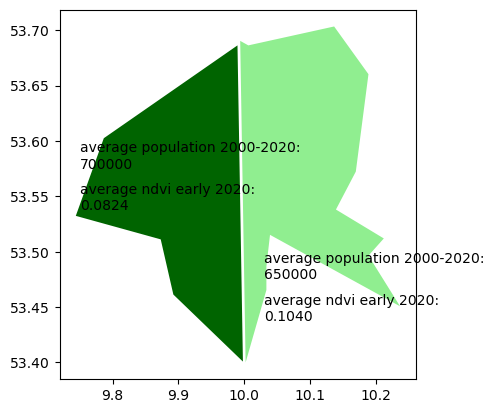

In [103]:
import matplotlib.pyplot as plt
gdf['color'] = ['#006400', '#90EE90']
gdf.plot(legend=True, color=gdf['color'])
va = ['bottom', 'top']
for idx, row in gdf.iterrows():
    coords = {0: (9.75, 53.6),
              1: (10.03, 53.5)}
    plt.annotate('average population 2000-2020:\n' + str(int((row['population']))), xy=coords[idx],
                 horizontalalignment='left', verticalalignment='top')
for idx, row in gdf.iterrows():
    coords = {0: (9.75, 53.535),
              1: (10.03, 53.435)}
    plt.annotate('average ndvi early 2020:\n' + f'{row["ndvi"]:.4f}', xy=coords[idx],
                 horizontalalignment='left', verticalalignment='bottom') 

In [ ]:
gc = openeo.connect('http://localhost:8080')
vc = gc.load_collection('openeo~hamburg')

In [ ]:
job.get_results().download_files("output")

In [ ]:
import inspect
inspect.getfullargspec(oc.upload_file)

In [ ]:
import inspect
inspect.getfullargspec(vc.aggregate_spatial)

In [ ]:
agg = olci_ndvi.aggregate_spatial(vc, 'mean')

In [ ]:
result = agg.save_result("GTiff")

In [ ]:
job = result.create_job()

In [ ]:
job.start_and_wait()

In [ ]:
job.get_results().download_files("output")

In [ ]:
result = olci_ndvi.save_result("GTiff")

In [ ]:
job = result.create_job()

In [ ]:
job.start_and_wait()

In [ ]:
job.get_results().download_files("output")